In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'students-performance-in-exams:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2478649%2F4204108%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240503%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240503T030011Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7662e5d76a0b134ab6a65ffca2381e8f39313b799179d7f768dfc89511c885370b661b9c285d731ebe0e0586f795ea0b6b3c5813cff59032fc6d420fd7a842fec7bbb84c3e6f50ac4de141297e4df31a700e4b024f53e8f5899a3e00aa495832df240ed890a3dc886e9f54d260d9577776b76877d7700b6fed49f23dbbf0345029a2b1e311b8a3560868fd4c6c1518e152236eac2886599fae4d6db3a79a433e74ad6cdcb3d228ea77046cb22fe1b4fbc447af14ba2d446c57a698465891e65a5420182099e7b96e72108ca60391ff688d98062b105c5eda20a41fcf3ef32e21130606ec392b7459b1b5ca82ded90933375cee24ed7619f69ec14dd8f25048d6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 8879 bytes downloaded
Downloaded and uncompressed: students-performance-in-exams
Data source import complete.


In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('dark')
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import os
import altair as alt


# Importing dataset
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/students-performance-in-exams/exams.csv


In [3]:
# Load the data
data = pd.read_csv("/kaggle/input/students-performance-in-exams/exams.csv")
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


# Exploring the data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


# Fields and data types 🗒️:
This table contains information on students' academic performance and background factors. It consists of the following columns:

* Gender: The gender of the student, represented as an object.
* Race/Ethnicity: The race or ethnicity of the student, represented as an object.
* Parental Level of Education: The educational level of the student's parents, represented as an object.
* Lunch: The type of lunch the student receives, represented as an object.
* Test Preparation Course: Whether the student completed a test preparation course, represented as an object.
* Math Score: The score obtained by the student in mathematics, represented as an integer.
* Reading Score: The score obtained by the student in reading, represented as an integer.
* Writing Score: The score obtained by the student in writing, represented as an integer.

In [5]:
data.shape

(1000, 8)

In [6]:
data.describe()

,math score,reading score,writing score
count,1000.000000,1000.000000,1000.000000
mean,66.396000,69.002000,67.738000
std,15.402871,14.737272,15.600985
min,13.000000,27.000000,23.000000
25%,56.000000,60.000000,58.000000
50%,66.500000,70.000000,68.000000
75%,77.000000,79.000000,79.000000
max,100.000000,100.000000,100.000000


In [7]:
data.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

In [8]:
# Renames the dataset and removes the space
data=data.rename(columns={
    "race/ethnicity":"race_ethnicity",
    "parental level of education":"Education",
    "test preparation course":"test_preparation_course",
    "math score":"math_score",
    "reading score":"reading_score",
    "writing score":"writing_score"
    })
data.head()

,gender,race_ethnicity,Education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


In [9]:
data.gender.value_counts()

gender
male      517
female    483
Name: count, dtype: int64

In [10]:
data[data.gender=="female"].race_ethnicity.value_counts(normalize=True)

race_ethnicity
group C    0.318841
group D    0.260870
group B    0.236025
group E    0.107660
group A    0.076605
Name: proportion, dtype: float64

In [11]:
data[data.gender=="male"].race_ethnicity.value_counts(normalize=True)

race_ethnicity
group C    0.326886
group D    0.263056
group B    0.176015
group E    0.152805
group A    0.081238
Name: proportion, dtype: float64

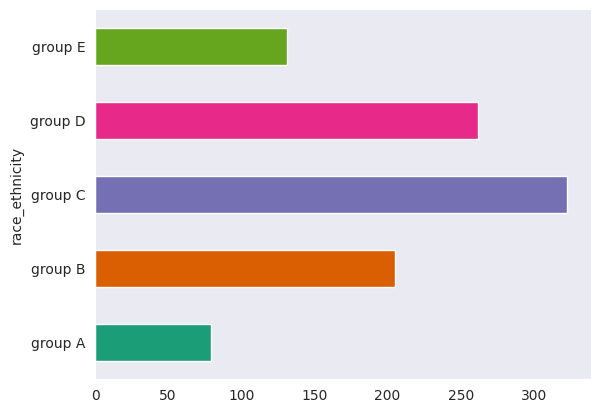

In [12]:
data.groupby('race_ethnicity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Now what is the number of males and females in each level of education?

In [13]:
data.groupby('Education')['gender'].value_counts()

Education           gender
associate's degree  male      122
                    female     81
bachelor's degree   female     58
                    male       54
high school         male      108
                    female     94
master's degree     female     42
                    male       28
some college        male      122
                    female    100
some high school    female    108
                    male       83
Name: count, dtype: int64

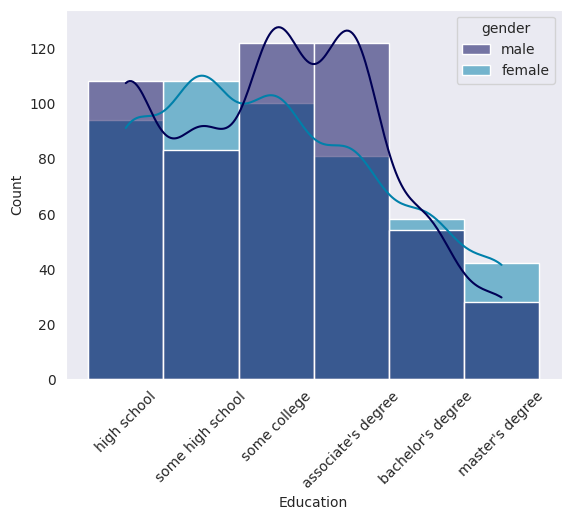

In [14]:
plt.xticks(rotation=45)
sns.histplot(data=data, x="Education", hue= "gender", palette="ocean",kde=True)
plt.show()

## what is the number of males/females in each group (race_ethnicity column)?

In [15]:
data.groupby('race_ethnicity')['gender'].value_counts()

race_ethnicity  gender
group A         male       42
                female     37
group B         female    114
                male       91
group C         male      169
                female    154
group D         male      136
                female    126
group E         male       79
                female     52
Name: count, dtype: int64

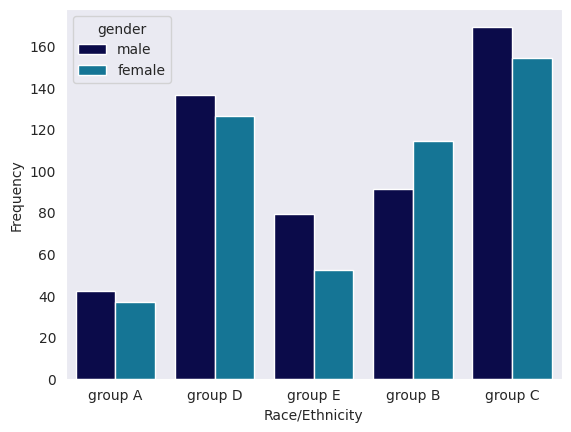

In [16]:
sns.countplot(x=data["race_ethnicity"], hue=data["gender"], palette="ocean")
plt.xlabel("Race/Ethnicity")
plt.ylabel("Frequency")
plt.show()

In [17]:
data["race_ethnicity"].value_counts()

race_ethnicity
group C    323
group D    262
group B    205
group E    131
group A     79
Name: count, dtype: int64

##  People in group C than others.


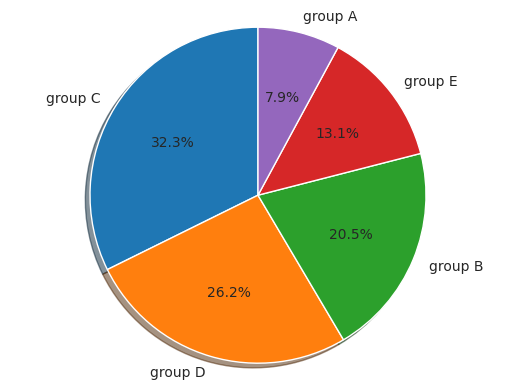

In [18]:
# Ordered and plotted counter-clockwise
labels = data["race_ethnicity"].value_counts().index
sizes = data["race_ethnicity"].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

## What is the number of parental level of education in each group?

In [19]:
data.groupby('race_ethnicity')['Education'].value_counts()

race_ethnicity  Education         
group A         some college          20
                high school           15
                bachelor's degree     14
                some high school      11
                associate's degree    11
                master's degree        8
group B         some college          49
                associate's degree    40
                high school           39
                some high school      38
                bachelor's degree     20
                master's degree       19
group C         associate's degree    75
                some college          69
                some high school      66
                high school           58
                bachelor's degree     35
                master's degree       20
group D         high school           59
                some college          57
                some high school      51
                associate's degree    50
                bachelor's degree     29
                master

## What is the number of students who completed and didn't complete the test_preparation_course in each group?

In [20]:
data.groupby('test_preparation_course')['race_ethnicity'].value_counts()

test_preparation_course  race_ethnicity
completed                group C           102
                         group D            84
                         group B            72
                         group E            45
                         group A            32
none                     group C           221
                         group D           178
                         group B           133
                         group E            86
                         group A            47
Name: count, dtype: int64

## What is the number of students who completed and didn't complete the test_preparation_course in level of education?

In [21]:
data.groupby('test_preparation_course')['Education'].value_counts()

test_preparation_course  Education         
completed                some college           82
                         associate's degree     75
                         some high school       63
                         high school            57
                         bachelor's degree      39
                         master's degree        19
none                     high school           145
                         some college          140
                         associate's degree    128
                         some high school      128
                         bachelor's degree      73
                         master's degree        51
Name: count, dtype: int64

In [22]:
data.Education.value_counts()

Education
some college          222
associate's degree    203
high school           202
some high school      191
bachelor's degree     112
master's degree        70
Name: count, dtype: int64

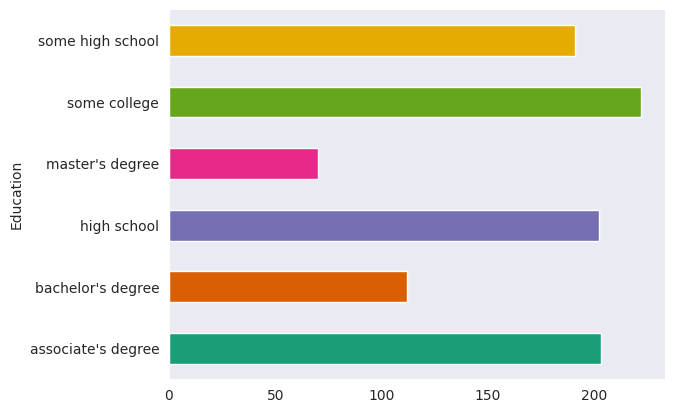

In [23]:
data.groupby('Education').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

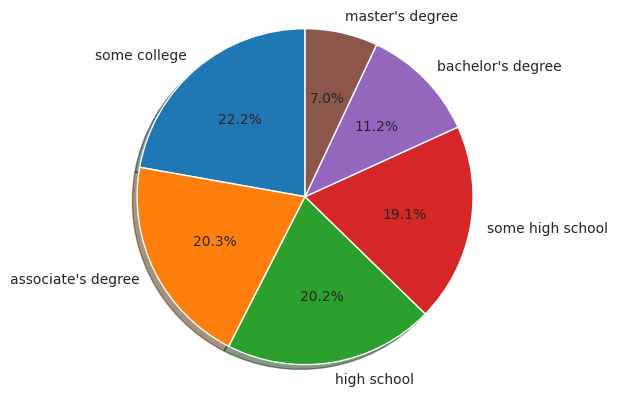

In [24]:
labels = data["Education"].value_counts().index
sizes = data["Education"].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

## The results of the examns

<Axes: xlabel='writing_score', ylabel='Count'>

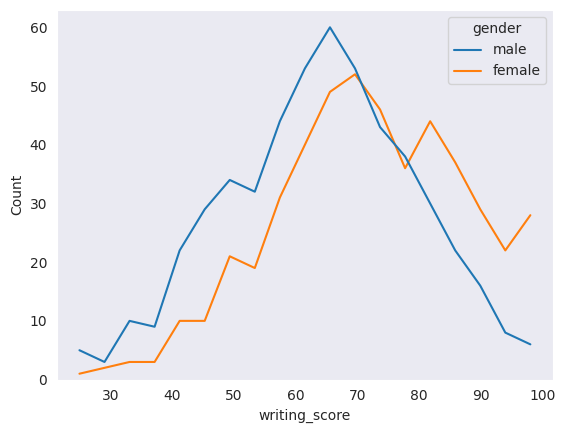

In [25]:
sns.histplot(x = 'writing_score', hue = 'gender', data = data, element = 'poly', fill=False)

<Axes: xlabel='math_score', ylabel='Count'>

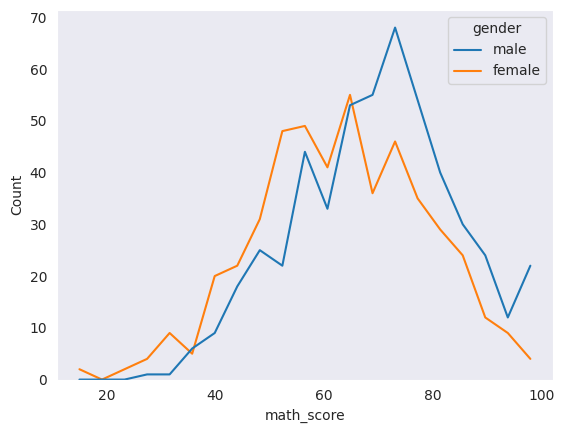

In [26]:
sns.histplot(x = 'math_score', hue = 'gender', data = data, element = 'poly', fill=False)

<Axes: xlabel='reading_score', ylabel='Count'>

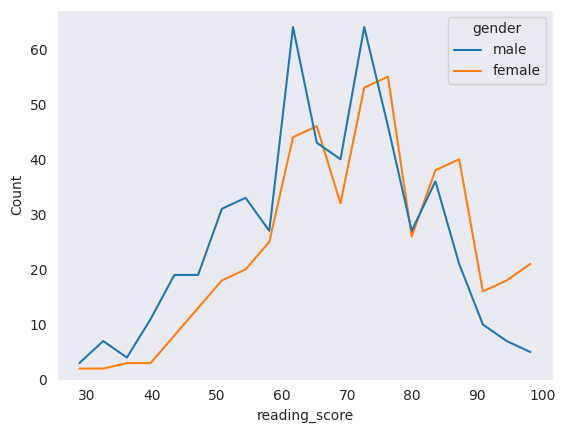

In [27]:
sns.histplot(x = 'reading_score', hue = 'gender', data = data, element = 'poly', fill=False)

## Who got more full marks, male or female?

In [28]:
people_with_fullmarks_in_math = data[data['math_score'] == 100]['math_score'].count()
print("Total people that marks 100 in Math:",people_with_fullmarks_in_math)
number_of_females = data[(data['math_score'] == 100)& (data['gender']=='female')]['math_score'].count()
print("Number of females who had 100 marks in Math:",number_of_females)
number_of_males = people_with_fullmarks_in_math - number_of_females
print("Number of males who had 100 marks in Math:",number_of_males)

Total people that marks 100 in Math: 14
Number of females who had 100 marks in Math: 3
Number of males who had 100 marks in Math: 11


In [29]:
people_with_fullmarks_in_reading = data[data['reading_score'] == 100]['reading_score'].count()
print("Total people that marks 100 in reading exam:",people_with_fullmarks_in_reading)
number_of_females = data[(data['reading_score'] == 100)& (data['gender']=='female')]['reading_score'].count()
print("Number of females who had 100 marks in reading exam:",number_of_females)
number_of_males = people_with_fullmarks_in_reading - number_of_females
print("Number of males who had 100 marks in reading exam:",number_of_males)

Total people that marks 100 in reading exam: 19
Number of females who had 100 marks in reading exam: 17
Number of males who had 100 marks in reading exam: 2


In [30]:
people_with_fullmarks_in_writing = data[data['writing_score'] == 100]['writing_score'].count()
print("Total people that marks 100 in writing exam:",people_with_fullmarks_in_writing)
number_of_females = data[(data['writing_score'] == 100)& (data['gender']=='female')]['writing_score'].count()
print("Number of females who had 100 marks in writing exam:",number_of_females)
number_of_males = people_with_fullmarks_in_writing - number_of_females
print("Number of males who had 100 marks in writing exam:",number_of_males)

Total people that marks 100 in writing exam: 18
Number of females who had 100 marks in writing exam: 15
Number of males who had 100 marks in writing exam: 3


<ipython-input-31-708b9873459b>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=data,x="test_preparation_course",y="math_score",kind="bar",palette="crest")


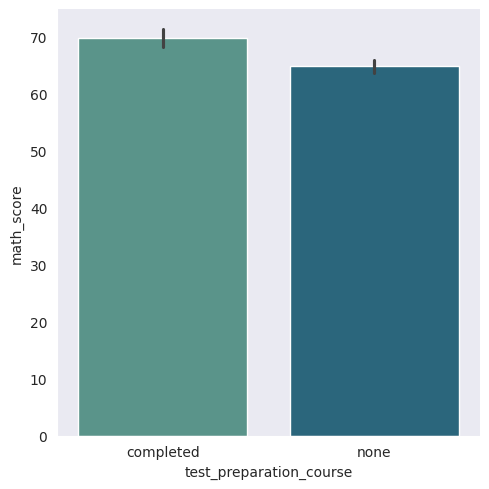

In [31]:
sns.catplot(data=data,x="test_preparation_course",y="math_score",kind="bar",palette="crest")
plt.show()

<ipython-input-32-eefa97d1d84c>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=data,x="test_preparation_course",y="reading_score",kind="bar",palette="crest")


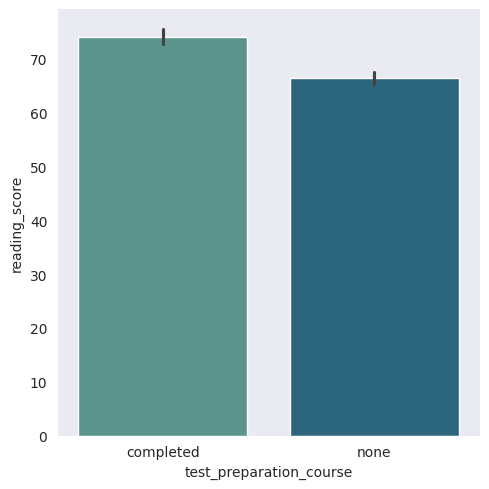

In [32]:
sns.catplot(data=data,x="test_preparation_course",y="reading_score",kind="bar",palette="crest")
plt.show()

<ipython-input-33-946133a53ec9>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=data,x="test_preparation_course",y="writing_score",kind="bar",palette="crest")


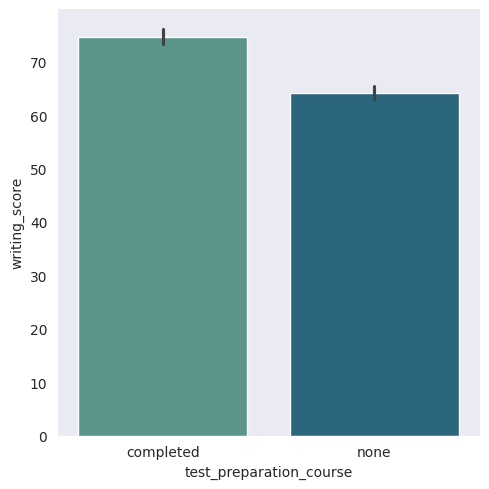

In [33]:
sns.catplot(data=data,x="test_preparation_course",y="writing_score",kind="bar",palette="crest")
plt.show()

In [34]:
# Relationship between reading score less than 50 and complete test preparation course
data[(data['reading_score'] < 50)]['test_preparation_course'].value_counts()

test_preparation_course
none         89
completed    14
Name: count, dtype: int64

In [35]:
# Relationship between math score less than 50 and complete test preparation course
data[(data['math_score'] < 50)]['test_preparation_course'].value_counts()

test_preparation_course
none         110
completed     35
Name: count, dtype: int64

In [36]:
#  Relationship between writing score less than 50 and complete test preparation course
data[(data['writing_score'] < 50)]['test_preparation_course'].value_counts()

test_preparation_course
none         120
completed     17
Name: count, dtype: int64

## Diference in the average

In [37]:
maths = data.groupby(["race_ethnicity"])["math_score"].mean()
maths

race_ethnicity
group A    65.215190
group B    63.170732
group C    63.130031
group D    69.267176
group E    74.465649
Name: math_score, dtype: float64

In [38]:
reading = data.groupby(["race_ethnicity"])["reading_score"].mean()
reading

race_ethnicity
group A    68.556962
group B    67.102439
group C    66.383901
group D    72.087786
group E    72.526718
Name: reading_score, dtype: float64

In [39]:
writing = data.groupby(["race_ethnicity"])["writing_score"].mean()
writing

race_ethnicity
group A    66.974684
group B    65.736585
group C    64.523220
group D    72.259542
group E    70.213740
Name: writing_score, dtype: float64

In [40]:
data_final = data[["Education", "math_score", "reading_score", "writing_score"]].groupby(["Education"]).mean().sort_values(by="math_score", ascending=False)
data_final

,math_score,reading_score,writing_score
Education,,,
master's degree,71.585714,75.428571,75.885714
bachelor's degree,71.491071,74.008929,74.410714
associate's degree,69.536946,70.985222,70.113300
some college,65.297297,68.045045,66.734234
high school,65.207921,67.400990,64.846535
some high school,60.701571,64.408377,62.539267
